# Development of coordinate generation, lattice placement, and symmetry group functionality

## Bounding occupancy of minimum-size cubic lattices

In [ ]:
from polymerist.maths.lattices.coordinates import Coordinates, BoundingBox
from polymerist.maths.lattices.integral import CubicIntegerLattice
from rdkit import Chem
from rdkit.Chem.AllChem import Compute2DCoords, EmbedMolecule
from rdkit.Chem import rdGeometry, rdMolTransforms
from rdkit.Geometry import Point3D
from polymerist.polymers.monomers.specification import expanded_SMILES
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

p = 3
N = 1E6
n = np.arange(1, N+1)
a = np.floor(N / n)
d = np.ceil(a**(1/p))
c = d**p
theta = a / c

# plt.loglog(n, theta)
plt.plot(n, theta)

plt.axhline(1, color='r')
plt.axhline(0.5**(p-1), color='r')
print(theta.min(), 0.5**(p-1))

## Playing with lattice generation (i.e. generating non-cubic lattices)

In [ ]:
from math import ceil
import numpy as np
import matplotlib.pyplot as plt

from polymerist.maths.lattices.integral import CubicIntegerLattice, nearest_int_coord_along_normal, generate_int_lattice
from polymerist.maths.lattices.bravais import COMMON_UNIT_LATTICE_VECTORS, LatticeParameters, identify_bravais_points_within_bbox
from polymerist.maths.lattices.coordinates import Coordinates, BoundingBox

### Generate Argon atom XYZ coordinates of reference unit vector transformed versions of an integer lattice

In [ ]:
from pathlib import Path
from rdkit import Chem
from rdkit.Chem.AllChem import Compute2DCoords, EmbedMolecule
from rdkit.Geometry import Point3D


d = 4
dims = np.array([d, d, d])
latt = CubicIntegerLattice(dims)

aff = np.eye(4)
aff[:-1, -1] = 0.5
bound_points = CubicIntegerLattice(dims + 1).affine_transformation(aff)
bbox = BoundingBox(bound_points)

outdir = Path('lattices')
outdir.mkdir(exist_ok=True)
for name, lattice_vectors in COMMON_UNIT_LATTICE_VECTORS.items():
    lp = LatticeParameters.from_lattice_vectors(lattice_vectors)
    print(name, lp.lengths, lp.axial_angles(in_degrees=True), lp.volume)

    new_points = latt.points @ lattice_vectors.T
    contained_in_lattice = bbox.surrounds(new_points, strict=False)
    outside_lattice = ~contained_in_lattice

    new_points = np.mod(new_points - bbox.lower, bbox.dims)
    l_init = len(new_points)
    new_points = np.unique(new_points, axis=0)
    l_final = len(new_points)
    print(l_init - l_final)

    conf = Chem.Conformer()
    atom_smiles = []
    for i, point in enumerate(new_points):
        conf.SetAtomPosition(i, point.astype(float))
        atom_smiles.append('[Ar]')
    conf.Set3D(True)

    mol = Chem.MolFromSmiles('.'.join(atom_smiles))
    mol.AddConformer(conf)
    xyzpath = outdir / f'{name.lower()}.xyz'
    Chem.MolToXYZFile(mol, str(xyzpath))

### Development of Bravais-lattice-in-bouding-box calculation

In [ ]:
lattice_vectors = np.random.random((2,2)) * 2
# A = np.array([[1.70662421, 0.2153812 ],
#        [0.8585849 , 0.69584722]])

bbox_extrema = np.array([
    [ 0.0, 0.0],
    # [ 1.0, 3.6],
    [ 7.0, 14.4],
])
bbox = BoundingBox(bbox_extrema)

inner_brav_latt, brav_int_latt = identify_bravais_points_within_bbox(lattice_vectors, bbox)

s = 6
fig = plt.figure(figsize=(s, s))
ax  = fig.add_subplot()
ax.scatter([0], [0], color='k', marker='*') # plot the origin
bbox_rect = plt.Rectangle(bbox.minimum, *bbox.dims, edgecolor='b', facecolor='c', alpha=0.3)
ax.add_patch(bbox_rect)
# ax.scatter(*bbox.vertices.T, color='b')
ax.scatter(*lattice_vectors.T, color='m')

# ax.scatter(*inv_bbox_coords.points.T, color='y')
# ax.scatter(*integral_bounding_points.T, color='tab:orange')
# ax.scatter(*trial_latt_points.points.T, color='tab:purple')

ax.scatter(*inner_brav_latt.points.T , color='g')
ax.scatter(*brav_int_latt.odd_points.T, color='r')
ax.scatter(*brav_int_latt.even_points.T, color='b')

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

lattice_vectors = COMMON_UNIT_LATTICE_VECTORS['RHOMBOHEDRAL']
# lattice_vectors = COMMON_UNIT_LATTICE_VECTORS['HEXAGONAL']
int_latt = CubicIntegerLattice(np.array([4,4,4]))
bbox = BoundingBox(int_latt)

inner_brav_latt, brav_int_latt = identify_bravais_points_within_bbox(lattice_vectors, bbox)

s = 6
fig = plt.figure(figsize=(s, s))
ax  = fig.add_subplot(projection='3d')
ax.scatter(*np.zeros(inner_brav_latt.n_dims), color='k', marker='*') # plot the origin
# ax.scatter(*int_latt.points.T , color='g')
ax.scatter(*inner_brav_latt.points.T , color='m')
ax.scatter(*lattice_vectors.T , color='g')


bounding_vol = Poly3DCollection(bbox.face_coords, facecolor='c', edgecolor='b', alpha=0.3)
# ax.add_collection3d(bounding_vol)
# ax.scatter(*brav_int_latt.odd_points.T, color='r')
# ax.scatter(*brav_int_latt.even_points.T, color='b')


# bbox_rect = plt.Rectangle(bbox.minimum, *bbox.dims, edgecolor='b', facecolor='c', alpha=0.3)
# ax.add_patch(bbox_rect)
# # ax.scatter(*bbox.vertices.T, color='b')
# ax.scatter(*lattice_vectors.T, color='m')

# # ax.scatter(*inv_bbox_coords.points.T, color='y')
# # ax.scatter(*integral_bounding_points.T, color='tab:orange')
# # ax.scatter(*trial_latt_points.points.T, color='tab:purple')


In [ ]:
d = 3
bb = BoundingBox(np.array([
    [0]*d,
    [1]*d,
]))
print(bb.lex_ordered_points)
print(bb.face_indices)

### Computing bounding box face orientations from directed graph DFS traversal

In [ ]:
import networkx as nx
import numpy as np

G = nx.hypercube_graph(3).to_directed()

node_coords = np.array(G.nodes)
node_coords = node_coords[np.lexsort(node_coords.T)] # place in lex order along coordinates
init_node = tuple(node_coords[0]) # take lowest-coordinate node in lex order as starting point
for i, coords in enumerate(node_coords):
    G.nodes[tuple(coords)]['order'] = i
nx.draw(G, with_labels=True, labels=nx.get_node_attributes(G, 'order'))

faces = []

curr_face = []
curr_node = init_node
face_start_node = curr_node
visited = {node : False for node in G.nodes}
while G.degree[curr_node] > 0:
    visited[curr_node] = True
    if sum(visited.values()) == G.number_of_nodes():
        visited = {node : False for node in G.nodes}

    ordc = G.nodes[curr_node]['order'] # add the current node index to the current face
    print(ordc)
    curr_face.append(ordc) # add the current node index to the current face
    next_node = min((nb for nb in G.neighbors(curr_node) if not visited[nb]), key=lambda node : G.nodes[node]['order']) # choose neighbor which comes soonest in the vertex ordering to visit next

    if next_node == face_start_node: # close, record, and reset face when re-encountering the node the face started with
        print(curr_face)
        faces.append([i for i in curr_face])
        curr_face.clear()

    G.remove_edge(curr_node, next_node)
    if G.degree[next_node] > 0:
        curr_node = next_node
    

### Developing more efficient integer-in-polytope detection (beyond tight bounding box)

In [ ]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.spatial import Delaunay, delaunay_plot_2d

hull = ConvexHull(int_bounds)
ax1  = fig.add_subplot(1,2,2)

convex_hull_plot_2d(hull)
plt.show()

In [12]:
latt = CubicIntegerLattice(np.array([2,2,2]))

delaun  = Delaunay(latt.points)
# delaunay_plot_2d(delaun)
# plt.show()

In [13]:
delaun.points

array([[0., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 1.],
       [1., 0., 0.],
       [1., 0., 1.],
       [1., 1., 0.],
       [1., 1., 1.]])

In [14]:
delaun.points[delaun.simplices[0]]

array([[0., 1., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 0.]])

## Playing with cubic/octahedral symmetry groups

In [15]:
import numpy as np
from polymerist.graphics.plotutils import scatter_3D
from polymerist.maths.lattices.integral import generate_int_lattice

d : int = 4

# produce integer lattice
dims = np.array([d, d, d])
num_points = dims.prod()
lattice = generate_int_lattice(*dims)

# sort lexicographically
order = np.lexsort(lattice.T)
lattice = lattice[order]

# determine even and odd positions after sorting
index_is_odd = lattice.sum(axis=1) % 2
index_is_odd = index_is_odd.astype(bool)

# center lattice at the origin
COM = lattice.mean(axis=0)
lattice = lattice - COM # sort lexicographically and translate center of grid to origin

# print(order, lattice[order])

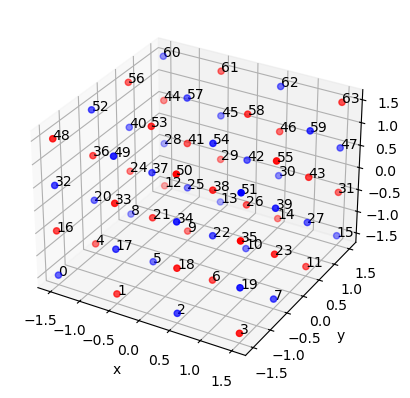

In [16]:
import matplotlib.pyplot as plt

alternate : bool = not False
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

if alternate:
    ax.scatter(*lattice[ index_is_odd].T, color='r')
    ax.scatter(*lattice[~index_is_odd].T, color='b')
else:
    ax.scatter(*lattice.T, color='r')

labels = np.lexsort(lattice.T)
for i, coords in zip(labels, lattice):
    ax.text(*coords, str(i))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In [17]:
from typing import Generator, Iterable
from itertools import permutations, product as cartesian_product
from polymerist.maths.combinatorics.permutations import Permutation, Cycle
from scipy.spatial.transform import Rotation, Slerp


def sign_alternations(n : int) -> Generator[tuple[int, int, int], None, None]:
    '''Generate every possible n-tuple containing either 1 or -1'''
    for signs in cartesian_product(*([1, -1] for _ in range(n))):
        yield signs

def orthogonal_basis_transforms(n : int=3) -> Generator[np.ndarray, None, None]:
    '''Generate all matrices in n-dimensions which permute or invert the standard basis vectors'''
    for signs in sign_alternations(n):
        matr = np.diag(signs)
        for perm in Permutation.symmetric_group(n):
            yield matr @ perm.matrix

def interpolate_linear_transformation(trans : np.ndarray, n_frames : int=10) -> np.ndarray:
    '''Accepts a linear transformation matrix (of size MxN) and a number of frames F
    Returns an FxMxN array containing uniforms "steps" between the identity and the desired transformation'''
    I = Rotation.identity()
    rot = Rotation.from_matrix(trans)
    full_rot = Rotation.concatenate([I, rot])
    interpolator = Slerp(np.linspace(0, 1, num=len(full_rot), dtype=int), full_rot)

    return interpolator(np.linspace(0, 1, num=n_frames)).as_matrix()

In [18]:
from collections import defaultdict

perms  = {}
all_cycles = {}

orbits = defaultdict(set)
stabilizers = defaultdict(list)

init_order = np.lexsort(lattice.T)
group_matrices = [el for el in orthogonal_basis_transforms(3)]
for i, trans in enumerate(group_matrices):
    new = lattice @ trans
    perms[i]      = perm   = Permutation(*np.lexsort(new.T))
    all_cycles[i] = cycles = perm.to_cycles(canonicalize=False)
    
    for cycle in cycles:
        if len(cycle) == 1:
            point_idx = cycle[0] # get the one element in the singleton cycle
            stabilizers[point_idx].append(trans)

        for point_idx in cycle:
            orbits[point_idx].update(cycle)

unique_orbits = set(tuple(sorted(orbit)) for orbit in orbits.values())
sum(len(i) for i in unique_orbits) == num_points

True

In [19]:
stab_sizes = {k : len(v) for k, v in stabilizers.items()}
for i in unique_orbits:
    print([stab_sizes[j] for j in i])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[6, 6, 6, 6, 6, 6, 6, 6]
[6, 6, 6, 6, 6, 6, 6, 6]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


### Visualize all symmetry actions as GIFs

In [20]:
from pathlib import Path
from math import ceil
from matplotlib.animation import FuncAnimation, ArtistAnimation, writers
from rich.progress import track


n_frames = 20

dir = Path('symmetry_actions')
dir.mkdir(exist_ok=True)

ax_max = ceil(d / 2)
ax_min = -ax_max

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.autoscale(False)

def update(frame_no : int):
    partial_rot = keyframes[frame_no, :, :]
    latt_pos = lattice @ partial_rot

    ax.clear()
    ax.set(xlim3d=(ax_min, ax_max), xlabel='X')
    ax.set(ylim3d=(ax_min, ax_max), ylabel='Y')
    ax.set(zlim3d=(ax_min, ax_max), zlabel='Z')

    return ax.scatter(*latt_pos.T)

for i, trans in track(enumerate(group_matrices), total=len(group_matrices), description='Visualizing symmetry group actions...'):
    keyframes = interpolate_linear_transformation(trans, n_frames=n_frames)
    ani = FuncAnimation(fig=fig, func=update, frames=len(keyframes), interval=10)
    ani.save(dir/f'symmetry_{i+1}.gif', writer='pillow')
    plt.close(fig)

Output()